DATA - 602 Final Project

From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

In this project I am trying predict dissatisfied customers. For this I would be using three models, namely :
1. Logistic Regression
2. Random Forest
3. Naive Bayes

I will also identify which model is best for prediction.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model 
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

/Users/dhananjay/Jupyter_vEnv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")#, index_col=['ID'])
test = pd.read_csv("test.csv")

In [3]:
df = pd.DataFrame(train.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train.shape[0]
df

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


Feature Exploration

In [4]:
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

In [5]:
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [6]:
# remove duplicated columns
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

In [7]:
train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

In [8]:
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1) #features
y = train.TARGET.values                # Target value

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1729)
print(X_train.shape, X_test.shape, test.shape)

((60816, 306), (15204, 306), (75818, 306))


In [10]:
## # Feature selection
clf = ExtraTreesClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)

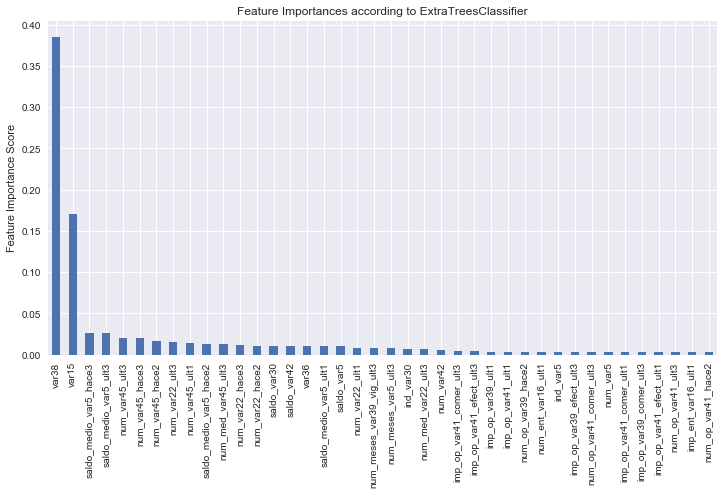

In [11]:
# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title='Feature Importances according to ExtraTreesClassifier', figsize=(12, 8))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.show()

In [12]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

In [13]:
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

# Logistic Regression

In [14]:
mod = linear_model.LogisticRegression()
mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
print("Roc AUC: ", roc_auc_score(y_test, mod.predict_proba(X_test)[:,1],
              average='macro'))

('Roc AUC: ', 0.56068781917223665)


In [16]:
probs = mod.predict_proba(X_test)

In [17]:
prob=probs[:,1]
prob_df=pd.DataFrame(prob)
prob_df['predicted_target']=np.where(prob_df[0]>=0.05,1,0)
prob_df['actual_target']=y_test
prob_df.head()

,0,predicted_target,actual_target
0,0.035267,0,0
1,0.035682,0,0
2,0.020034,0,0
3,0.020942,0,0
4,0.035268,0,0


In [18]:
predicted = mod.predict(X_test)
#print metrics.accuracy_score(Y_test, predicted)

In [19]:
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
print metrics.accuracy_score(y_test, predicted)

0.959089713233


In [21]:
confusion_matrix=pd.crosstab(prob_df['actual_target'],prob_df['predicted_target'])
confusion_matrix

predicted_target,0,1
actual_target,,
0,9018,5565
1,327,294


In [22]:
from __future__ import division
tn=9033
fp = 5550
fn=336
tp=285
senstivity = tp/(tp+fn)
specifity = fp/(fp+tn)

In [23]:
senstivity
specifity

0.3805801275457725

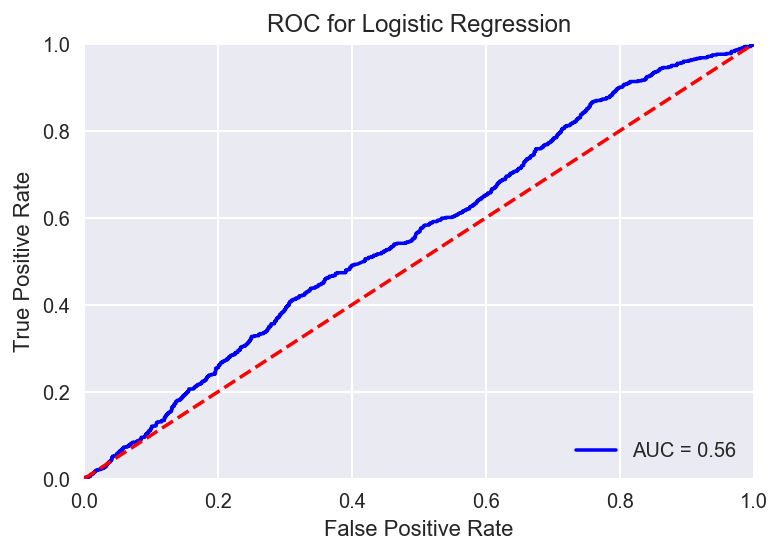

In [24]:
# calculate the fpr and tpr for all thresholds of the classification
probs = mod.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.title('ROC for Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest



In [25]:
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
# Define a classifier
rf_clf = RandomForestClassifier(max_depth=15,n_estimators=70, min_samples_leaf=50,
                                  min_samples_split=100, random_state=10)

# Train the model
rf_clf.fit(X_train,y_train)

/Users/dhananjay/Jupyter_vEnv/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=70, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [30]:
# Define a new Random Forest Classifier
select_rf_clf = RandomForestClassifier(random_state=10)

param_grid = {
    
            'n_estimators': [50, 80, 100],
            'max_depth': [5,10, 15]
}

# we will 10-fold cross-validation
grid_clf = GridSearchCV(select_rf_clf,param_grid,cv=5)
grid_clf.fit(X_train, y_train)

# Take the best model
best_rf_clf = grid_clf.best_estimator_

# Make prediction with test data
predicted_proba = best_rf_clf.predict_proba(X_train)

In [31]:
import matplotlib.pyplot as plt
from sklearn import cross_validation
import sklearn
from sklearn.metrics import roc_auc_score


print('Overall AUC:', roc_auc_score(y_train, predicted_proba[:,1]))


false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(y_train, predicted_proba[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)

('Overall AUC:', 0.89641124888894574)


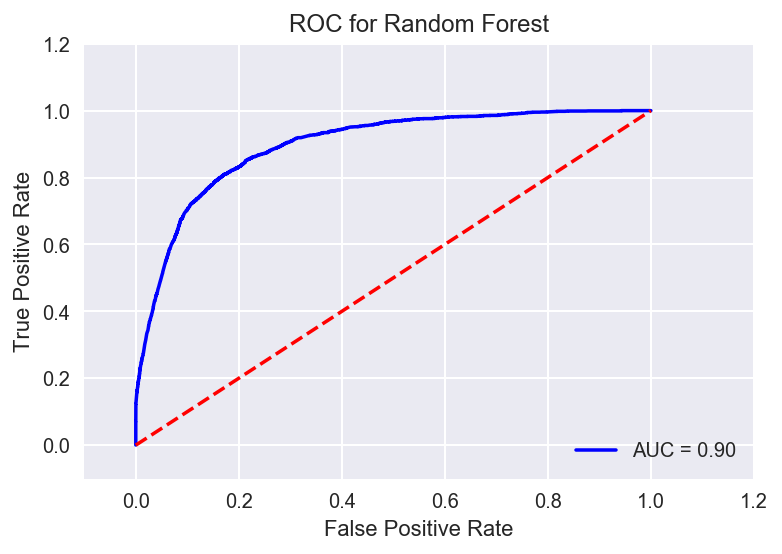

In [32]:
# Roc Curve
plt.title('ROC for Random Forest')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict_proba(X_test)

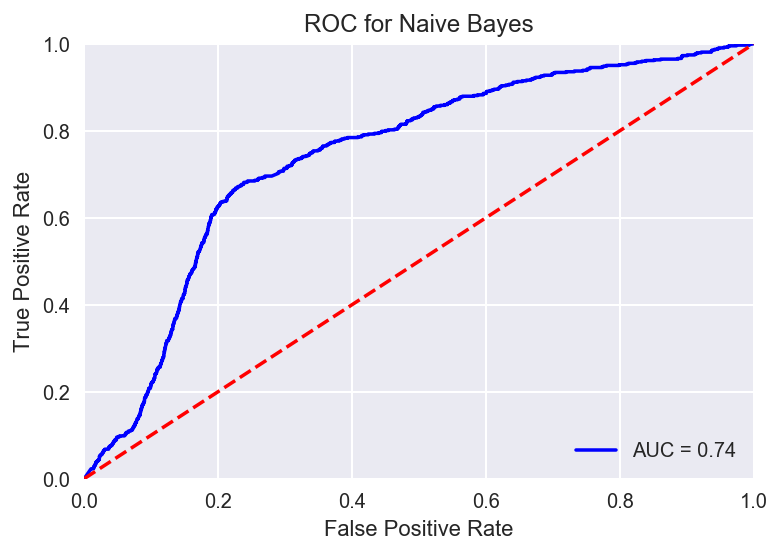

In [47]:
# calculate the fpr and tpr for all thresholds of the classification
probs1 = gnb.predict_proba(X_test)
preds1 = probs1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.title('ROC for Naive Bayes')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

We used three models namely Logistic Regression, Random Forest and Naive Bayes to predict Customer Satisfaction. 
The three models predicted Customer Satisfaction with following accuracy:
1. Logistic Regression: 56%
2. Random Forest: 90%
3. Naive Bayes: 74%

As seen above,Random Forest performed way better than Logistic regression and Naive Bayes and therefore we choose Random Forest over Logistic and Naive Bayes.